In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import yfinance as yf
from sklearn.preprocessing import StandardScaler

In [15]:
# df = pd.read_csv('airline-passengers.csv')
df = yf.download('ETH-USD')
df = df.drop(['Adj Close','Volume'], axis='columns')
df.head(1)

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2017-11-09,308.644989,329.451996,307.056,320.884003


In [16]:
# Adding daysofweek, weekofmonth and monthofyear to help the model identify seasonal patterns

df['Day'] = df.index.dayofweek # 0 represents monday and 6 represents sunday
df['Week'] = (df.index.day -1) // 7 +1 # days of month divided by 7 to get weeks
df['Month'] = df.index.month #1 represents janurary and 12 represents december
df.head(10)

,Open,High,Low,Close,Day,Week,Month
Date,,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,3,2,11
2017-11-10,320.670990,324.717987,294.541992,299.252991,4,2,11
2017-11-11,298.585999,319.453003,298.191986,314.681000,5,2,11
2017-11-12,314.690002,319.153015,298.513000,307.907990,6,2,11
2017-11-13,307.024994,328.415009,307.024994,316.716003,0,2,11
2017-11-14,316.763000,340.177002,316.763000,337.631012,1,2,11
2017-11-15,337.963989,340.911987,329.812988,333.356995,2,3,11
2017-11-16,333.442993,336.158997,323.605988,330.924011,3,3,11
2017-11-17,330.166992,334.963989,327.523010,332.394012,4,3,11


In [17]:
timeseries_values = df.values.astype('float32')
# Normalize the data
scaler = StandardScaler()
timeseries = scaler.fit_transform(timeseries_values)
# Then, later, once we have predicted data, we can call scaler.inverse_transform(predicted_data)
# Print the scale so we get an idea of how much it was scaled by
print("Not scaled array: ", timeseries_values[0])
print("Scaled array: ",timeseries[0])

Not scaled array:  [308.645 329.452 307.056 320.884   3.      2.     11.   ]
Scaled array:  [-8.3120352e-01 -8.2078946e-01 -8.2443827e-01 -8.2112885e-01
 -6.6804001e-04 -5.5592108e-01  1.2471730e+00]


In [18]:
# Choose how much past data a prediction is based on
seq_length = 50 # days
train_test_split_percentage = 0.75
batch_size = 16 # not optimized yet
feature_amount = timeseries[0].size #

# Define a function to create in/out sequence data
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw-1):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq , train_label))
    return inout_seq

inout_seq = create_inout_sequences(timeseries, seq_length)

# Split data into train and test sets
train_size = int(len(inout_seq) * train_test_split_percentage)
train_set = inout_seq[:train_size]
test_set = inout_seq[train_size:]

# Convert inout_seq to tensors inside the list comprehension
train_data = data.TensorDataset(
    torch.stack([torch.FloatTensor(s[0]) for s in train_set]),
    torch.stack([torch.FloatTensor(s[1]) for s in train_set]))
train_loader = data.DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)

test_data = data.TensorDataset(
    torch.stack([torch.FloatTensor(s[0]) for s in test_set]),
    torch.stack([torch.FloatTensor(s[1]) for s in test_set]))
test_loader = data.DataLoader(test_data, shuffle=False, batch_size=batch_size, drop_last=True)

In [36]:
class StockPricePredictorLSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(StockPricePredictorLSTM, self).__init__()
        self.input_size = input_size
        # TODO: MAKE THE HIDDEN LAYER SIZE PROPOTIONAL TO THE INPUT LAYER SIZE
        self.hidden_layer_1_size = input_size*25 # since 4*25 equals 100
        self.hidden_layer_2_size = input_size*10 # since 4*15 equals 60
        self.hidden_layer_3_size = input_size*5 # since 4*5 equals 20
        self.output_size = output_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_layer_1_size, batch_first=True)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(self.hidden_layer_1_size, self.hidden_layer_2_size)
        self.linear2 = nn.Linear(self.hidden_layer_2_size, self.hidden_layer_3_size)
        self.linear3 = nn.Linear(self.hidden_layer_3_size, self.output_size)

        # self.hidden_cell = (torch.zeros(1, batch_size,self.hidden_layer_size),
        #                     torch.zeros(1, batch_size, self.hidden_layer_size))

    def forward(self, input_seq):
        out, _ = self.lstm(input_seq)
        # lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        # lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
        out = self.relu(out)
        out = self.linear(out[:,-1,:])
        out = self.relu(out)
        out = self.linear2(out)
        out = self.relu(out)
        out = self.linear3(out)
        return out

# Initialize model
model = StockPricePredictorLSTM(input_size=feature_amount,output_size=feature_amount)
model.cuda()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

# Train the model
epochs = 300
for i in range(epochs):
    # Size 32,10,4 and 32,1,4 respectively
    for seq, labels in train_loader:
        seq, labels = seq.cuda(), labels.view(-1, feature_amount).cuda()

        model.train()
        optimizer.zero_grad()
        # Reset the hidden state. Avoid using states across batches.
        # model.hidden_cell = (torch.zeros(1, seq.size(0), model.hidden_layer_size).cuda(),
                            #  torch.zeros(1, seq.size(0), model.hidden_layer_size).cuda())

        y_pred = model(seq)
        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

    # Reduce the learning rate and increase the regularization as time goes on
    # It's kind of Gradient Descent
    if i == 100:
        for g in optimizer.param_groups:
          g['lr'] = 0.005
    elif i == 200:
        for g in optimizer.param_groups:
          g['lr'] = 0.0001
          g['weight_decay'] = 1e-4

    # Evaluate on the whole test set every 25 epochs
    if i%25 == 0:
        with torch.no_grad():
            model.eval()
            test_losses = []
            test_predictions = []

            # Iterate over test data
            for seq, labels in test_loader:
                seq, labels = seq.cuda(), labels.view(-1, feature_amount).cuda()
                y_pred = model(seq)
                test_predictions.append(test_predictions)
                test_loss = loss_function(y_pred, labels)
                test_losses.append(test_loss.item())
            # Report the average test loss
            avg_test_loss = np.mean(test_losses)
        print(f'epoch: {i:3} train loss: {loss.item():10.6f}, test loss: {avg_test_loss:10.8f}')

print(f'epoch: {i:3} train loss: {loss.item():10.6f} test loss: {avg_test_loss:10.8f}')

epoch:   0 train loss:   0.361535, test loss: 0.26141640
epoch:  25 train loss:   0.019285, test loss: 0.05361393
epoch:  50 train loss:   0.028842, test loss: 0.02638433
epoch:  75 train loss:   0.022096, test loss: 0.02587806
epoch: 100 train loss:   0.026370, test loss: 0.02716200
epoch: 125 train loss:   0.013211, test loss: 0.02252446
epoch: 150 train loss:   0.032694, test loss: 0.02063828
epoch: 175 train loss:   0.002787, test loss: 0.02139884
epoch: 200 train loss:   0.004349, test loss: 0.02117128
epoch: 225 train loss:   0.009110, test loss: 0.01717060
epoch: 250 train loss:   0.002576, test loss: 0.01681923
epoch: 275 train loss:   0.026741, test loss: 0.01688615
epoch: 299 train loss:   0.020169 test loss: 0.01688615


In [37]:
def predict_n_days_ahead(n):
    # Move the model to evaluation mode
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        # We don't use the test_loader, because its easier to evaluate without the chunking
        seq = torch.stack([torch.FloatTensor(s[0]) for s in test_set]).cuda()
        # To predict n days in advance, we'll iterate and feed predictions back as input n times
        for i in range(n):
            preds = model(seq) # shape [test_size, feature_amount]
            preds = preds.unsqueeze(1) # shape [test_size, 1, feature_amount]
            # Now we can use add the prediction to the sequence
            seq = torch.cat((seq, preds), dim=1) # shape [test_size, seq_length + 1, feature_amount]
            # and drop the oldest sequence entry
            seq = seq[:, 1:, :] # shape [test_size, seq_length, feature_amount]
        final = np.array(preds.squeeze(1).cpu())
        return final


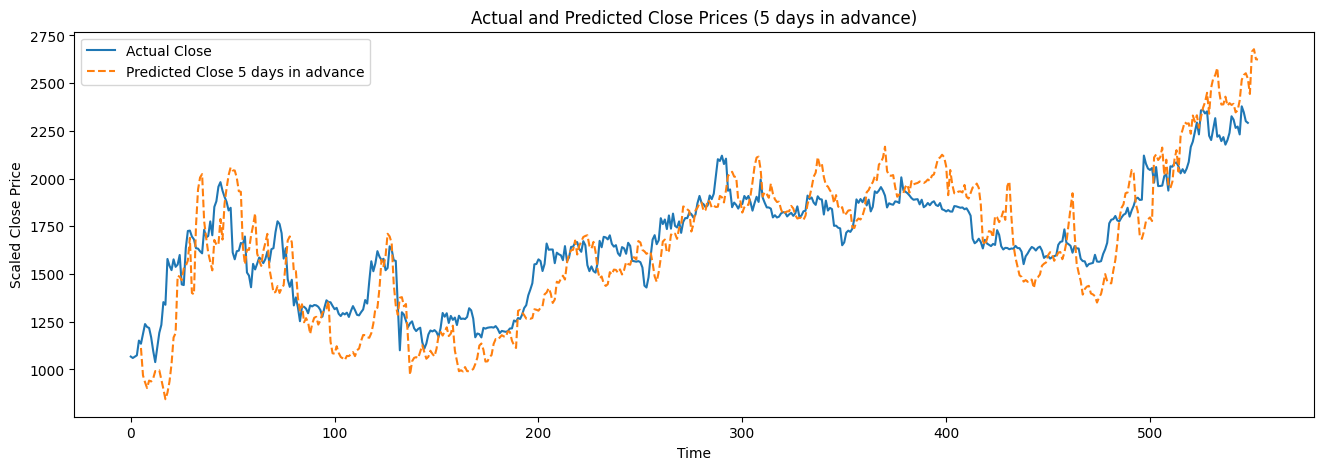

In [38]:
n_ahead = 5
empty_items = np.empty((n_ahead)) * np.nan
metric_to_look_at = 3 # 0 for Open, 1 for High, 2 for Low, 3 for Close

# Note that this starts at day seq_length of the test set, because of the chunking
original = torch.stack([torch.FloatTensor(s[0]) for s in test_set])[:,-1,:]
denormalized = scaler.inverse_transform(original)
denormalized_close = np.concatenate((denormalized[:,metric_to_look_at], empty_items))

# Starts at prediction for day seq_length + n_ahead, so we pad the start
predicted_n_days = predict_n_days_ahead(n_ahead)
denormalized_predicted_n_days = scaler.inverse_transform(predicted_n_days)
denormalized_predicted_n_days_close = np.concatenate((empty_items, denormalized_predicted_n_days[:,metric_to_look_at]))

plt.figure(figsize=(16,5))
plt.title(f'Actual and Predicted Close Prices ({n_ahead} days in advance)')
plt.xlabel('Time')
plt.ylabel('Scaled Close Price')
plt.plot(denormalized_close, label='Actual Close')
plt.plot(denormalized_predicted_n_days_close, label=f'Predicted Close {n_ahead} days in advance', linestyle='--')
plt.legend()
plt.show()

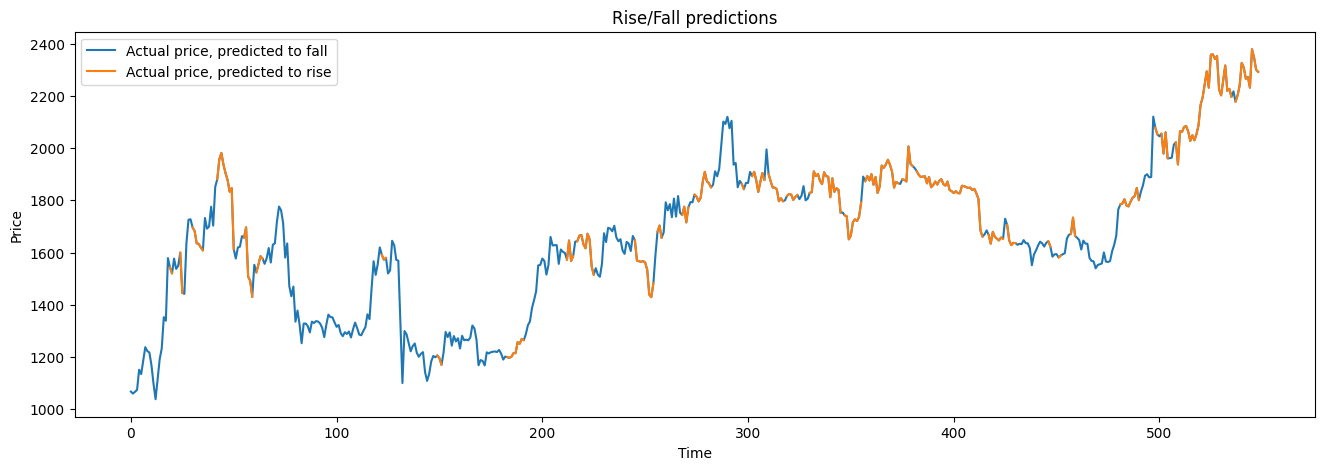

In [41]:
n_ahead = 1
metric_to_look_at = 3

original = torch.stack([torch.FloatTensor(s[0]) for s in test_set])[:,-1,:]
denormalized = scaler.inverse_transform(original)
denormalized_price = denormalized[:,metric_to_look_at]

predicted_n_days = predict_n_days_ahead(n_ahead)
denormalized_predicted_n_days = scaler.inverse_transform(predicted_n_days)
denormalized_predicted_n_days_price = denormalized_predicted_n_days[:,metric_to_look_at]

going_up = np.where(denormalized_predicted_n_days_price > denormalized_price, denormalized_price, np.nan)
non_nan_count = np.sum(~np.isnan(going_up))

plt.figure(figsize=(16,5))
plt.title(f'Rise/Fall predictions')
plt.xlabel('Time')
plt.ylabel('Price')
plt.plot(denormalized_price, label='Actual price, predicted to fall')
plt.plot(going_up, label=f'Actual price, predicted to rise')
plt.legend()
plt.show()

In [44]:
def extrapolate_n_days(sequence, n):
    # Move the model to evaluation mode
    model.eval()
    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for i in range(n):
            preds = model(sequence)
            sequence = torch.cat((sequence, preds.unsqueeze(1)), dim=1)
        return sequence

test_seqs = torch.stack([torch.FloatTensor(s[0]) for s in test_set]).cuda()

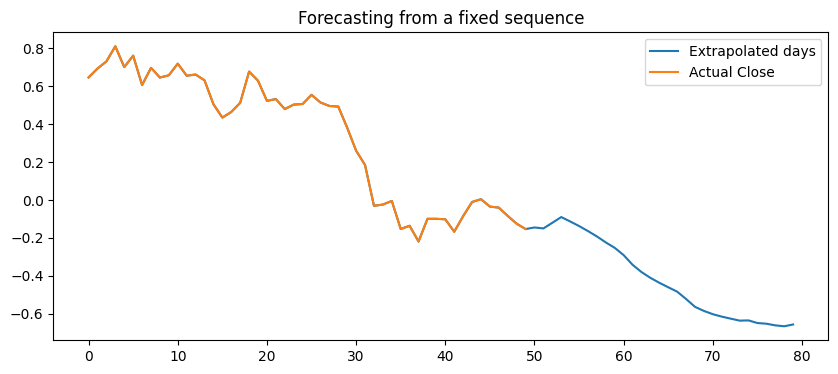

In [45]:
plt.figure(figsize=(10,4))
plt.title(f'Forecasting from a fixed sequence')
plt.plot(extrapolate_n_days(test_seqs[:1], 30).squeeze(0)[:,metric_to_look_at].cpu(), label='Extrapolated days')
plt.plot(np.array(test_seqs[:1].cpu()).squeeze(0)[:,metric_to_look_at], label='Actual Close')
plt.legend()
plt.show()